In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime

In [2]:
runtime = datetime.datetime.now() # first run

In [3]:
# Yüklenen dosyayı okuma
train_df = pd.read_csv("cure_the_princess_train.csv")
test_df = pd.read_csv("cure_the_princess_test.csv")
validation_df = pd.read_csv("cure_the_princess_validation.csv")

In [4]:
# Seed ayarlama
torch.manual_seed(180401043)
# Batch size seçilir
batch_size = 16

from torch.utils.data import DataLoader, TensorDataset

# TensorDataset kullanarak train, test ve validation setlerini oluşturuyoruz
train_inputs = train_df.drop('Cured', axis=1).values
train_labels = train_df['Cured'].values
train_dataset = TensorDataset(torch.tensor(train_inputs, dtype=torch.float), torch.tensor(train_labels, dtype=torch.long))

val_inputs = validation_df.drop('Cured', axis=1).values
val_labels = validation_df['Cured'].values
val_dataset = TensorDataset(torch.tensor(val_inputs, dtype=torch.float), torch.tensor(val_labels, dtype=torch.long))

test_inputs = test_df.drop('Cured', axis=1).values
test_labels = test_df['Cured'].values
test_dataset = TensorDataset(torch.tensor(test_inputs, dtype=torch.float), torch.tensor(test_labels, dtype=torch.long))

# DataLoader kullanarak train, test ve validation setlerini batch'ler halinde modele veriyoruz
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Train veri yükleyici (DataLoader) - veriyi batch'ler halinde yükler, karıştırır
test_loader = DataLoader(test_dataset, batch_size=batch_size) # Test veri yükleyici (DataLoader) - veriyi batch'ler halinde yükler
val_loader = DataLoader(val_dataset, batch_size=batch_size) # Validation veri yükleyici (DataLoader) - veriyi batch'ler halinde yükler


In [5]:
# Modeli oluşturma
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [6]:
input_size=len(train_df.columns) - 1
hidden_size1=100
hidden_size2=50
output_size=2
# GPU ve CPU için
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Model tanımlama
model = MLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

In [7]:
#Loss fonksiyonu belirliyoruz
criterion = nn.CrossEntropyLoss()

#Optimizasyon yöntemi ve parametreleri belirliyoruz
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [8]:
num_epochs = 50
train_acc_list = [] # Train doğruluk (accuracy) listesi
val_acc_list = [] # Validation doğruluk (accuracy) listesi
train_loss_list = [] # Train kaybı (loss) listesi
val_loss_list = [] # Validation kaybı (loss) listesi

best_val_acc = 0.0 # En iyi doğruluk değeri
patience = 5 # Sabır seviyesi, epoch sayısı

for epoch in range(num_epochs):
    # Train the model
    model.train()
    correct=0
    train_loss = 0 # Train kaybı (loss) başlangıç değeri
    total_train = 0 # Toplam train veri sayısı
    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every few iterations
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        train_loss += loss.item() * inputs.size(0)
        total_train += inputs.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)  # Değişiklik burada
        correct += (predicted == labels).sum().item()
    
    # Calculate train accuracy
    train_acc = correct / total_train
    train_acc_list.append(train_acc)
    train_loss /= total_train
    train_loss_list.append(train_loss)

    # Evaluate the model on validation set every epoch
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0 # Validation kaybı (loss) başlangıç değeri
        for inputs, labels in val_loader:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)  # Değişiklik burada
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_loss += loss.item() * inputs.size(0)

        val_acc = correct / total
        val_acc_list.append(val_acc)
        val_loss /= total
        val_loss_list.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

          # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Validation accuracy after epoch {epoch+1}: {val_acc:.4f}")
        break

Epoch [1/50], Train Loss: 0.7222, Train Acc: 0.5080, Val Loss: 0.7036, Val Acc: 0.4968
Epoch [2/50], Train Loss: 0.6887, Train Acc: 0.5455, Val Loss: 0.6766, Val Acc: 0.5732
Epoch [3/50], Train Loss: 0.6723, Train Acc: 0.6190, Val Loss: 0.6621, Val Acc: 0.6306
Epoch [4/50], Train Loss: 0.6598, Train Acc: 0.6629, Val Loss: 0.6485, Val Acc: 0.6911
Epoch [5/50], Train Loss: 0.6479, Train Acc: 0.7085, Val Loss: 0.6360, Val Acc: 0.7134
Epoch [6/50], Train Loss: 0.6372, Train Acc: 0.7300, Val Loss: 0.6245, Val Acc: 0.7516
Epoch [7/50], Train Loss: 0.6274, Train Acc: 0.7460, Val Loss: 0.6147, Val Acc: 0.7707
Epoch [8/50], Train Loss: 0.6186, Train Acc: 0.7596, Val Loss: 0.6053, Val Acc: 0.7898
Epoch [9/50], Train Loss: 0.6099, Train Acc: 0.7684, Val Loss: 0.5936, Val Acc: 0.8185
Epoch [10/50], Train Loss: 0.6014, Train Acc: 0.7835, Val Loss: 0.5845, Val Acc: 0.8248
Epoch [11/50], Train Loss: 0.5936, Train Acc: 0.7923, Val Loss: 0.5753, Val Acc: 0.8248
Epoch [12/50], Train Loss: 0.5860, Train 

In [9]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Train ve validation setlerinden elde edilen tahminler
train_preds = []
val_preds = []

# Train seti için tahminleri topla
for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    train_preds.extend(predicted.cpu().numpy())

# Validation seti için tahminleri topla
for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    val_preds.extend(predicted.cpu().numpy())

# Gerçek etiketleri topla
train_labels = []
val_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.numpy())
    
for _, labels in val_loader:
    val_labels.extend(labels.numpy())

# Accuracy hesapla
train_acc = accuracy_score(train_labels, train_preds)
val_acc = accuracy_score(val_labels, val_preds)

# Precision hesapla
train_precision = precision_score(train_labels, train_preds, average='weighted')
val_precision = precision_score(val_labels, val_preds, average='weighted')

# F1 score hesapla
train_f1 = f1_score(train_labels, train_preds, average='weighted')
val_f1 = f1_score(val_labels, val_preds, average='weighted')

# Recall hesapla
train_recall = recall_score(train_labels, train_preds, average='weighted')
val_recall = recall_score(val_labels, val_preds, average='weighted')

# Sonuçları yazdır
print(f"Train Accuracy: {train_acc:.4f}, Train Precision: {train_precision:.4f}, Train F1 Score: {train_f1:.4f}, Train Recall: {train_recall:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Validation Precision: {val_precision:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Recall: {val_recall:.4f}")


Train Accuracy: 0.5096, Train Precision: 0.5102, Train F1 Score: 0.5092, Train Recall: 0.5096
Validation Accuracy: 0.9013, Validation Precision: 0.9026, Validation F1 Score: 0.9012, Validation Recall: 0.9013


In [10]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Test seti için tahminleri topla
test_preds = []
test_labels = []
model.eval() # Modeli değerlendirme moduna getir
with torch.no_grad(): # Gradyan hesaplamalarını kapat
    for inputs, labels in test_loader:
       inputs = inputs.to(device)
       labels = labels.to(device)
       outputs = model(inputs)
       _, predicted = torch.max(outputs.data, 1)
       test_preds.extend(predicted.cpu().numpy())
       test_labels.extend(labels.cpu().numpy())


# Accuracy hesapla
test_acc = accuracy_score(test_labels, test_preds)

# Precision hesapla
test_precision = precision_score(test_labels, test_preds)

# F1 score hesapla
test_f1 = f1_score(test_labels, test_preds)

# Recall hesapla
test_recall = recall_score(test_labels, test_preds)

# Sonuçları yazdır
print(f"Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test F1 Score: {test_f1:.4f}, Test Recall: {test_recall:.4f}")
print(test_dataset[1])
inputs = test_dataset[1][0].to(device)  # inputs tensörünü uygun cihaza taşı
outputs = model(inputs)
print(outputs)




Test Accuracy: 0.8459, Test Precision: 0.8321, Test F1 Score: 0.8499, Test Recall: 0.8686
(tensor([31.6000,  1.9000, 25.2000, 17.9000, 16.4000,  2.4000,  4.2000,  6.4000,
        32.5000, 21.9000, 19.7000, 12.4000, 17.4000]), tensor(1))
tensor([0.1030, 0.7652], device='cuda:0', grad_fn=<SigmoidBackward0>)


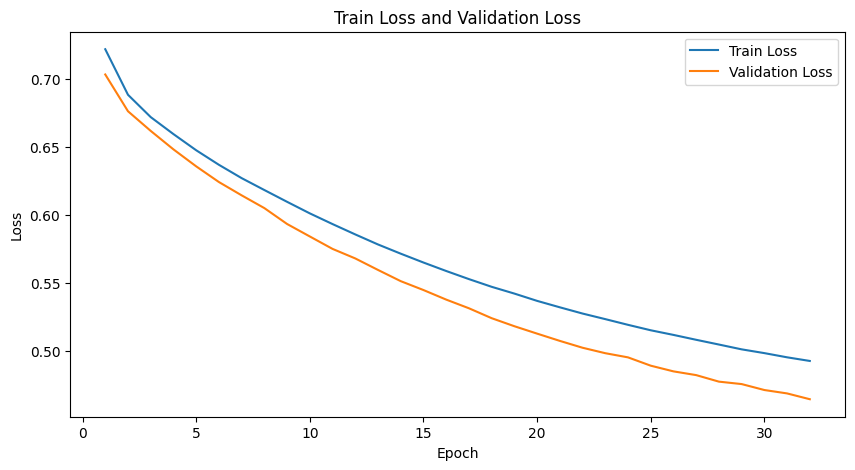

In [12]:
import matplotlib.pyplot as plt
num_epochs=32
# Loss değerlerini görselleştir
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss and Validation Loss')
plt.legend()
plt.show()


In [ ]:
runtime2 = datetime.datetime.now() # end run
print(f"Kodun çalışma süresi: {device} ", runtime2-runtime)